In [1]:
import scvelo
import sys
import ot
import scipy as sp
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
import sklearn as sk
from sklearn import manifold 
import pandas as pd

In [2]:
adata = scvelo.datasets.dentategyrus_lamanno(); adata.obs.celltypes = adata.obs.clusters
adata.obs["start_prob"] = pd.read_csv("../../data/dentate_gyrus/start_probs.csv", index_col = 0).start_prob
adata.obs["end_prob"] = pd.read_csv("../../data/dentate_gyrus/end_probs.csv", index_col = 0).end_prob
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.obs["reads"] = np.array(adata.X.sum(-1)).flatten()
adata.obs["logreads"] = np.log(adata.obs["reads"])
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset = True)
sc.pp.scale(adata, max_value=10)
sc.pp.subsample(adata, n_obs = 5000, random_state = 0)

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/ann

In [3]:
adata.uns['iroot'] = np.argmax(adata.obs.start_prob)

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:316: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


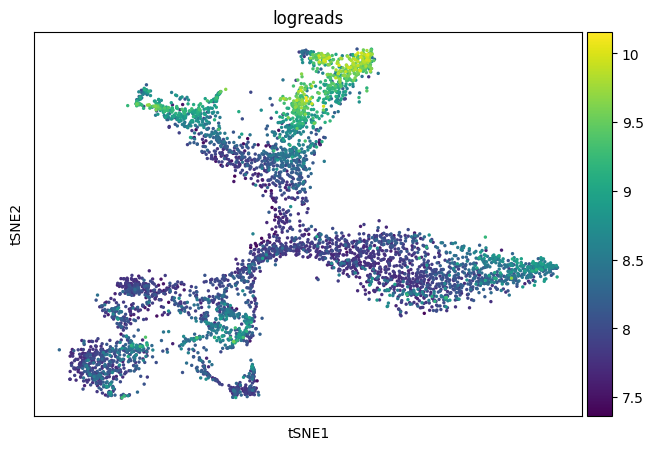

In [4]:
sc.pp.pca(adata, n_comps = 50)
sc.pl.scatter(adata, basis = "tsne", color = "logreads", )

In [5]:
# save as file and run julia script
X = adata.X; np.save("X.npy", X)

In [291]:
# !julia --project=. ../../src/kernel_cmd.jl X.npy 1.0 --mode quad --out_W W_quad.npy --out_u u_quad.npy --diag_inf true
!julia --project=. ../../src/kernel_cmd.jl X.npy 0.008 --mode ent --out_W W_ent.npy --out_u u_ent.npy --diag_inf true

[ Info: Loading input file X.npy
[ Info: Calculating kernel
 19.841602 seconds (8.97 M allocations: 1.365 GiB, 4.67% gc time, 14.09% compilation time)
[ Info: Writing output to W_ent.npy, u_ent.npy


In [292]:
W, u = np.load("W_quad.npy"), np.load("u_quad.npy")
W_ent, u_ent = np.load("W_ent.npy"), np.load("u_ent.npy")

In [293]:
np.sort(np.unique(adata.obs.clusters))

array(['CA', 'CA1-Sub', 'CA2-3-4', 'GlialProg', 'Granule', 'ImmAstro',
       'ImmGranule1', 'ImmGranule2', 'Nbl1', 'Nbl2', 'OPC', 'RadialGlia',
       'RadialGlia2', 'nIPC'], dtype=object)

In [299]:
adata.obs.loc[:, "nbrs"] = (W > 0).sum(-1)
adata.obs.loc[:, "u"] = u

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:316: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


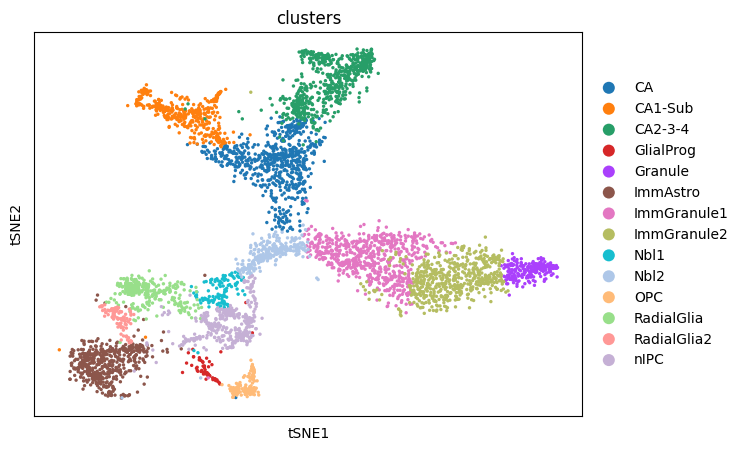

In [300]:
sc.pl.scatter(adata, basis = "tsne", color = "clusters", save = "dentategyrus_clusters.svg")

In [410]:
import plotly
import plotly.express as px
# Compute spectral embeddings
embed_op = manifold.SpectralEmbedding(n_components = 10, affinity = "precomputed", n_jobs = 16, random_state = 0)
# Quadratic kernel
X_emb_quad = embed_op.fit_transform(W)
# Entropic kernel
X_emb_ent = embed_op.fit_transform(W_ent)
# kNN 
knn_op = sk.neighbors.NearestNeighbors(n_neighbors = 50, algorithm = "auto", n_jobs = 16)
knn_op.fit(X)
A = knn_op.kneighbors_graph(X)
A = (A + A.T)/2
X_emb_knn = embed_op.fit_transform(np.array(A.todense()))

Text(0.5, 1.0, 'kNN, k = 50')

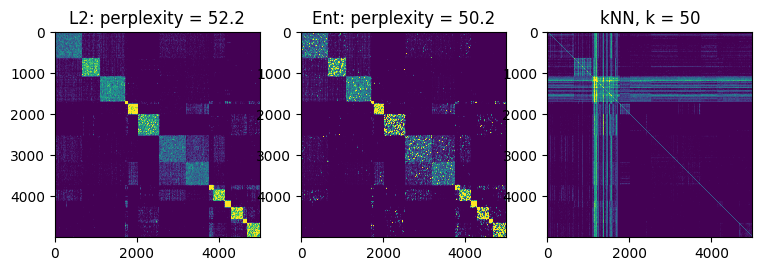

In [548]:
def perplexity(M):
    return np.exp(-(sp.special.xlogy(M, M)).sum(-1))
idx = np.array(np.argsort(adata.obs.clusters))
plt.figure(figsize = (9, 3))
plt.subplot(1, 3, 1)
plt.imshow(W[idx, :][:, idx], vmax = 3e-3)
plt.title(f"L2: perplexity = {perplexity(W).mean():.1f}")
plt.subplot(1, 3, 2)
plt.imshow(W_ent[idx, :][:, idx], vmax = 3e-3)
plt.title(f"Ent: perplexity = {perplexity(W_ent).mean():.1f}")
plt.subplot(1, 3, 3)
plt.imshow(np.asarray(A.todense() / A.sum(-1).mean())[idx, :][:, idx], vmax = 3e-3)
plt.title("kNN, k = 50")

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


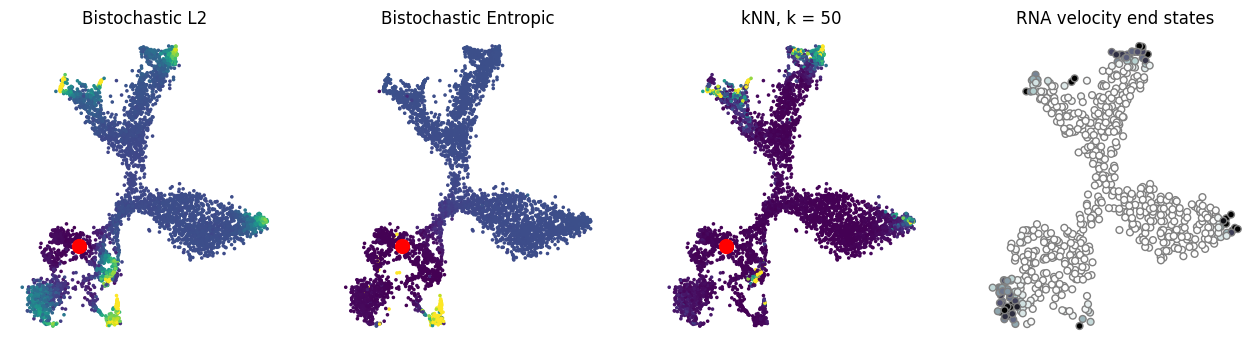

In [549]:
plt.figure(figsize = (16, 4))
plt.subplot(1, 4, 1)
z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_quad, "sqeuclidean"))[adata.uns['iroot'], :]
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, s = 2.5, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True)
plt.scatter(adata.obsm["X_tsne"][[adata.uns['iroot'], ], 0], adata.obsm["X_tsne"][[adata.uns['iroot'], ], 1], c = 'r', s = 100)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.axis("off")
plt.title("Bistochastic L2")

plt.subplot(1, 4, 2)
z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_ent, "sqeuclidean"))[adata.uns['iroot'], :]
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, s = 2.5, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True)
plt.scatter(adata.obsm["X_tsne"][[adata.uns['iroot'], ], 0], adata.obsm["X_tsne"][[adata.uns['iroot'], ], 1], c = 'r', s = 100)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.axis("off")
plt.title("Bistochastic Entropic")

plt.subplot(1, 4, 3)
z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_knn, "sqeuclidean"))[adata.uns['iroot'], :]
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, s = 2.5, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True)
plt.scatter(adata.obsm["X_tsne"][[adata.uns['iroot'], ], 0], adata.obsm["X_tsne"][[adata.uns['iroot'], ], 1], c = 'r', s = 100)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.axis("off")
plt.title("kNN, k = 50")

plt.subplot(1, 4, 4)
idx = np.where(~adata.obs.start_prob.isna())[0]
z = adata[idx, :].obs.end_prob # - adata[idx, :].obs.start_prob 
plt.scatter(adata.obsm["X_tsne"][idx, 0], adata.obsm["X_tsne"][idx, 1], c = z, s = 24, alpha = 1.0, cmap = "bone_r", vmax = np.quantile(z, 0.975), vmin = 0, edgecolor = 'grey')
plt.axis("off")
plt.title("RNA velocity end states")

plt.savefig("../figures/dentategyrus_spectral_embedding_distance.pdf", dpi = 300)

In [550]:
lineage_sets = {"CA" : ["CA", "CA2-3-4"], 
                "ImmGranule" : ["ImmGranule1", "ImmGranule2", "Granule"],
                "ImmAstro" : ["ImmAstro"]}

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


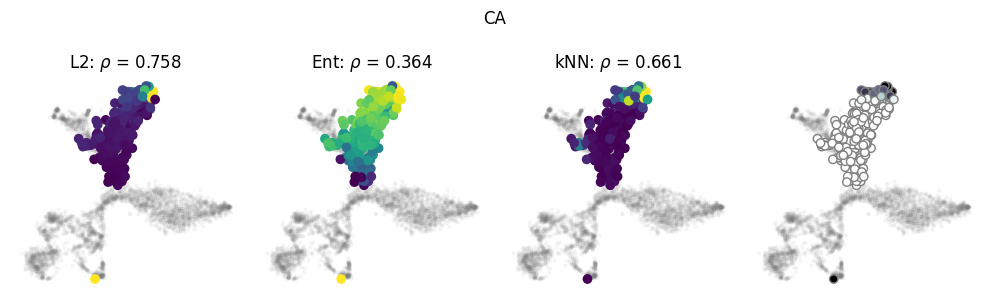

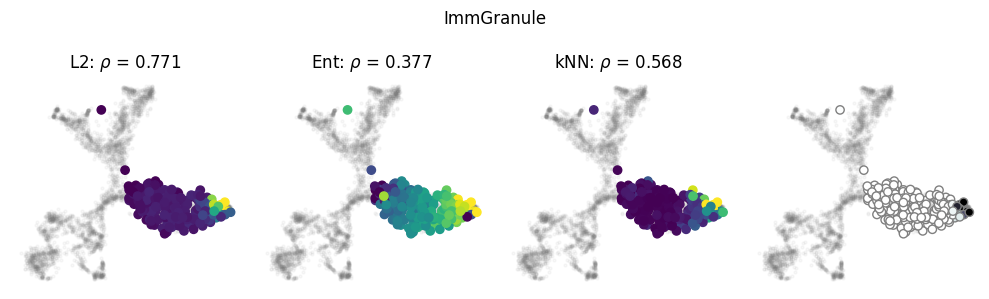

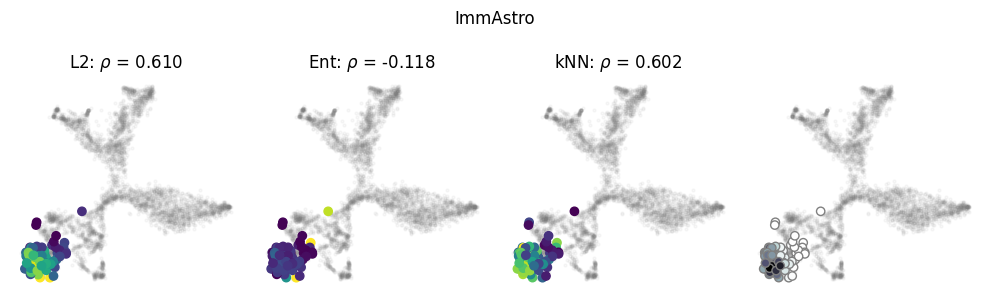

In [551]:
for (k, v) in lineage_sets.items():
    idx = np.where((~adata.obs.end_prob.isna()) & adata.obs.clusters.isin(v))[0]
    adata_subset = adata[idx, :]
    plt.figure(figsize = (10, 3))
    plt.subplot(1,4,4)
    z = adata_subset.obs.end_prob 
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = z, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True, cmap = "bone_r", edgecolor = 'grey')
    plt.axis("off")
    plt.subplot(1,4,1)
    _z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_quad, "sqeuclidean"))[adata.uns['iroot'], idx]
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = _z, vmax = np.quantile(_z, 0.975), vmin = np.quantile(_z, 0.025), rasterized = True)
    plt.axis("off")
    plt.title(f"L2: $\\rho$ = {sp.stats.pearsonr(z, _z).statistic:.3f}")
    plt.subplot(1,4,2)
    _z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_ent, "sqeuclidean"))[adata.uns['iroot'], idx]
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = _z, vmax = np.quantile(_z, 0.975), vmin = np.quantile(_z, 0.025), rasterized = True)
    plt.axis("off")
    plt.title(f"Ent: $\\rho$ = {sp.stats.pearsonr(z, _z).statistic:.3f}")
    plt.subplot(1,4,3)
    _z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_knn, "sqeuclidean"))[adata.uns['iroot'], idx]
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = _z, vmax = np.quantile(_z, 0.975), vmin = np.quantile(_z, 0.025), rasterized = True)
    plt.axis("off")
    plt.title(f"kNN: $\\rho$ = {sp.stats.pearsonr(z, _z).statistic:.3f}")
    plt.suptitle(k)
    plt.tight_layout()